# Detecção de Alvos lineares em imagens de Sonar

## Imports

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.color import label2rgb

## Constants

In [2]:
IMAGE_PATH = "images/204145.png"
# IMAGE_PATH = "images/204146.png"

## Load Image

In [3]:
raw_image = cv.imread(IMAGE_PATH)[:, :, 0]

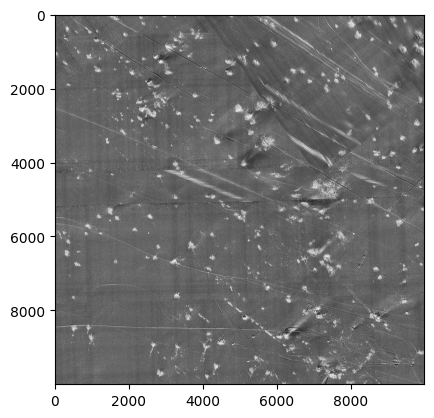

In [4]:
plt.imshow(raw_image, cmap = "gray")

In [5]:
raw_image.shape

(10000, 10000)

## Histogram Equalization

In [6]:
clahe = cv.createCLAHE(clipLimit = 10, tileGridSize = (3,3))
cl1 = clahe.apply(raw_image)

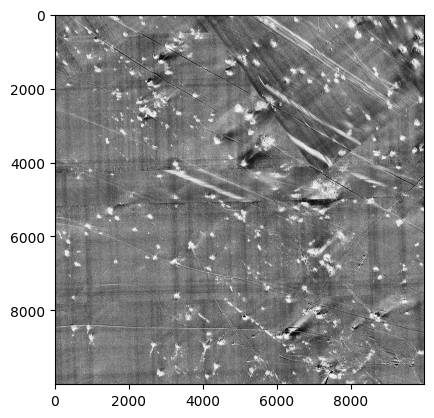

In [7]:
plt.imshow(cl1, cmap = "gray")

## Detect Horizontal Lines with Morphology

In [8]:
horizontal_size = cl1.shape[1] // 800

In [9]:
horizontal_structure = cv.getStructuringElement(cv.MORPH_RECT, (horizontal_size, 1))

In [10]:
horizontal_structure

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=uint8)

In [11]:
horizontal = cv.erode(cl1, horizontal_structure)
horizontal = cv.dilate(cl1, horizontal_structure)

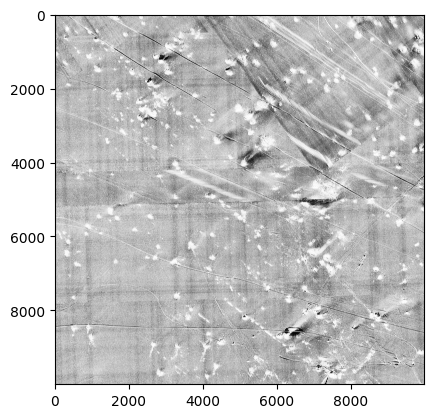

In [12]:
plt.imshow(horizontal, cmap = "gray")

In [13]:
horizontal_threshold = np.where(horizontal >= 225, 1, 0).astype(np.uint8)

In [14]:
horizontal_threshold.shape

(10000, 10000)

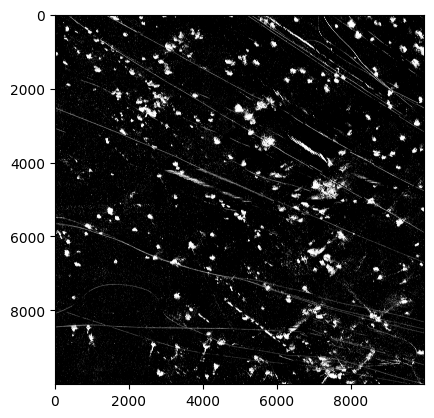

In [15]:
plt.imshow(horizontal_threshold, cmap = "binary_r")

## Detect Vertical Lines with Morphology

In [16]:
vertical_size = cl1.shape[0] // 500

In [17]:
vertical_structure = cv.getStructuringElement(cv.MORPH_RECT, (1, vertical_size))

In [18]:
vertical_structure

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=uint8)

In [19]:
vertical = cv.erode(cl1, vertical_structure)
vertical = cv.dilate(cl1, vertical_structure)

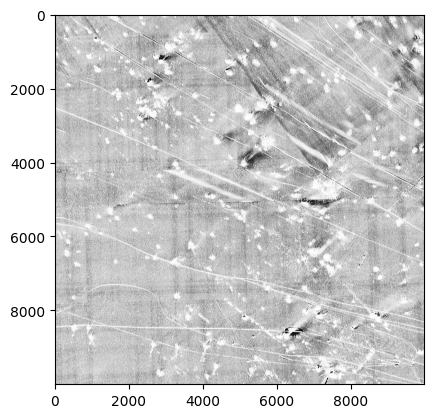

In [20]:
plt.imshow(vertical, cmap = "gray")

In [21]:
vertical_threshold = np.where(vertical >= 225, 1, 0).astype(np.uint8)

In [22]:
vertical_threshold.shape

(10000, 10000)

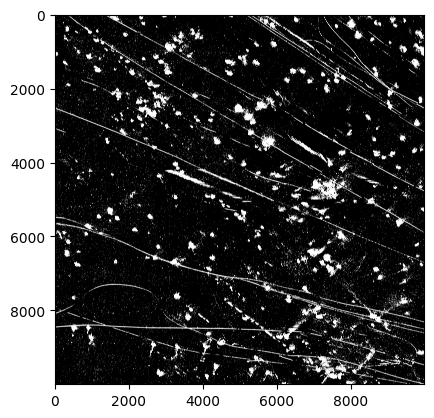

In [23]:
plt.imshow(vertical_threshold, cmap = "binary_r")

## Union Detect Lines

In [24]:
lines_threshold = cv.bitwise_or(horizontal_threshold, vertical_threshold)

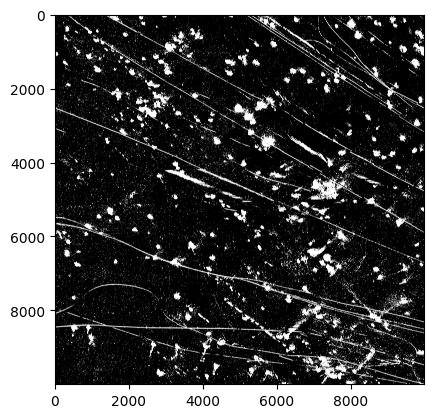

In [25]:
plt.imshow(lines_threshold, cmap = "binary_r")

## TO-DO
1. Testar equalização de histograma local com scikit-image
2. Após a transformada de hough, aplicar análise de componentes conexas
3. Manter somente objetos que tem maior length

In [26]:
# Análise de componentes conexas
label_image = label(lines_threshold)

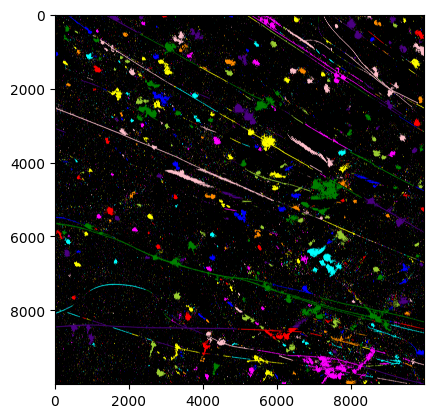

In [27]:
plt.imshow( label2rgb(label_image, bg_label=0) )

In [28]:
# Propriedades dos componentes conectados
properties = regionprops(label_image)

In [29]:
# Filtrar linhas baseadas em propriedades geométricas
# Ajuste os valores de limiar conforme necessário
min_eccentricity = 0.85  # Linhas tendem a ter alta excentricidade
min_major_axis_length = 60  # Ajuste baseado no tamanho esperado das linhas
max_minor_axis_length = 250  # Linhas devem ser estreitas\\\\

In [30]:
lines_mask = np.zeros_like(raw_image)

In [31]:
for prop in properties:
    if (prop.eccentricity > min_eccentricity and 
        prop.major_axis_length > min_major_axis_length and 
        prop.minor_axis_length < max_minor_axis_length
       ):
        # Marcar o componente como linha
        lines_mask[label_image == prop.label] = 1

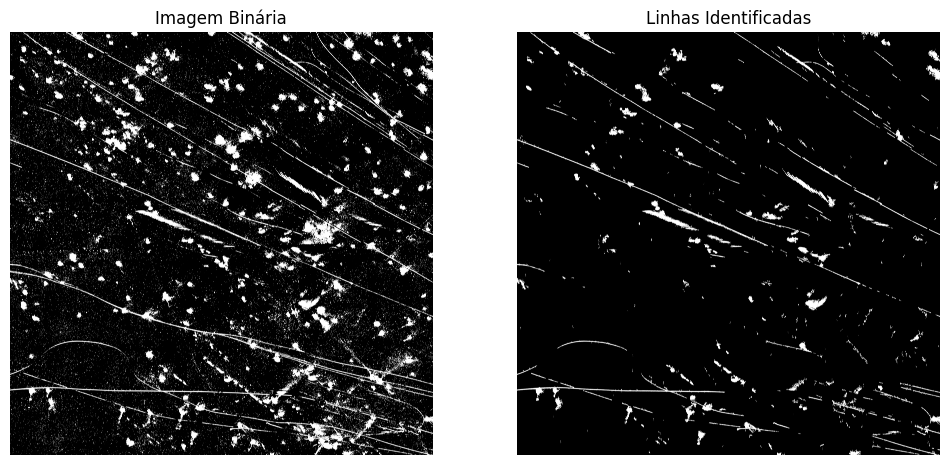

In [32]:
# Mostrar a imagem original e a imagem com as linhas identificadas
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(lines_threshold, cmap='gray')
ax[0].set_title('Imagem Binária')
ax[0].axis('off')

ax[1].imshow(lines_mask, cmap='gray')
ax[1].set_title('Linhas Identificadas')
ax[1].axis('off')

plt.show()